In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

Load data

In [2]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x)) for x,y,z in zip(impscores,onehot_data,hyp_impscores)]))==0

#Read in scores on the dinucleotide-shuffled sequences, taking
# the sum across ACGT at each position, to get an empirical null distribution
# of per-position importance scores
nulldist_perposimp = [
    np.array( [sum([float(z) for z in y.split(",")]) for
                y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_dnshuff_impscores.txt")]

Num onehot sequences: 960


In [3]:
!head seqlets.fa

>ex3:2-43
AAGGTTTGTCTTGTTATGCAGATAAGATCTCTCTGGTGATA
>ex3:127-168
CACAAAAGGGGAGATTTATATTCTATTGTTAGGCATTTAGG
>ex5:58-99
GCGCCCCACCTCCAGCTGTTCTCCTCAGGGATGCCTCATTC
>ex11:62-103
TTTTCTGGGCAGCAGGCAAGAACCCATCAGGTTGCTACACA
>ex15:52-93
CTGTGCTGGGGCCCTCATCTGCATCACAAAGTGGCCGTCTG


In [4]:
#loading the coords
import modisco.core
reload(modisco.core)

contrib_scores_track = modisco.core.DataTrack(name="contrib_scores",
                                 fwd_tracks=impscores,
                                 rev_tracks=[x[::-1, ::-1] for x in impscores])
hypcontrib_scores_track = modisco.core.DataTrack(name="hypcontrib_scores",
                                    fwd_tracks=hyp_impscores,
                                    rev_tracks=[x[::-1, ::-1] for x in hyp_impscores])
onehot_track = modisco.core.DataTrack(name="onehot",
                         fwd_tracks=onehot_data,
                         rev_tracks=[x[::-1, ::-1] for x in onehot_data])
track_set = modisco.core.DataTrackSet(data_tracks=[
                contrib_scores_track, hypcontrib_scores_track, onehot_track])

coords = []
for i,line in enumerate(open("seqlets.fa")):
    if (i%2==0):
        beforecolon, aftercolon = line.rstrip().split(":")
        example_idx = int(beforecolon[3:])
        start, end = aftercolon.split("-")
        start, end = int(start), int(end)
        coords.append(modisco.core.Coordinate(
                        example_idx=example_idx, start=start+10,
                        end=end-10, is_revcomp=False))
    
seqlets = track_set.create_seqlets(coords=coords, flanks=10)
    

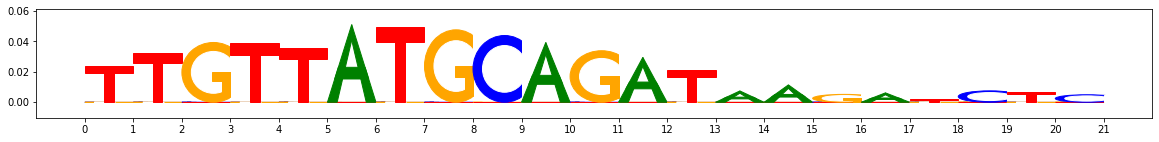

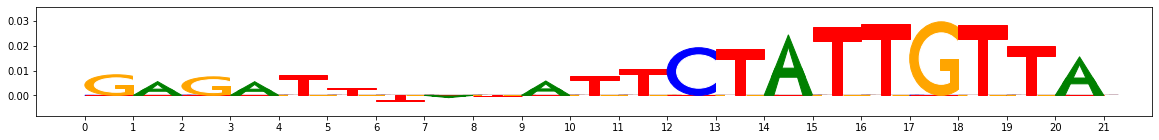

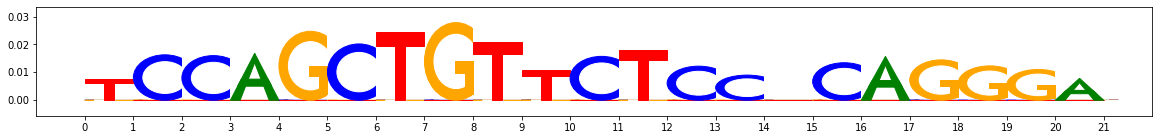

In [5]:
from modisco.visualization import viz_sequence

for seqlet in seqlets[:3]:
    viz_sequence.plot_weights(seqlet["contrib_scores"].corefwd)

In [6]:
%load_ext line_profiler

In [5]:
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.util
reload(modisco.util)

<module 'modisco.util' from '/Users/avantishrikumar/Research/modisco/modisco/util.py'>

In [30]:
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.util
reload(modisco.util)
import gc
gc.collect()

affmat_computer = modisco.affinitymat.SequenceAffmatComputer_Impute(
                    metric=modisco.util.l1norm_contin_jaccard_sim,
                    n_jobs=1, min_overlap_frac=0.6)

affmat, offsets, isfwdmat = affmat_computer(seqlets[:100], onehot_trackname="onehot",
                                            hyp_trackname="hypcontrib_scores")

(100, 17)
(100,)
(100,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: `indices` and `arr` must have the same number of dimensions

In [17]:
isfwdmat.shape

(500, 500, 500)

In [15]:
arow = affmat[:,0]
offsetsinrow = offsets[:,0]
isfwdrow = isfwdmat[:,0]
seqletssubset = seqlets[:500]
sortedindices = np.argsort(arow)[::-1]
for idx in sortedindices[:10]:
    print(idx,arow[idx], offsetsinrow[idx], isfwdrow[idx])
    if (isfwdrow[idx]):
        print("corefwd",idx)
        viz_sequence.plot_weights(seqletssubset[idx]["contrib_scores"].corefwd)
    else:
        print("corerev",idx)
        viz_sequence.plot_weights(seqletssubset[idx]["contrib_scores"].corerev)

[177 320 281 428 396 194 419 468 275 485  79  36  74 493 225 149 219 486
 213 103 326 310 276 200 455 317 178 312   3 192  63 444 473 346 292 316
 191  72 183 457 176  78 384 165 204 377  82 338  89 123 345  93 247 189
 150 108 352 114 369 426 217 229 220 459 228 262 499 388  22 288  27  31
 491 285 324 282  43 278 495 293  64 272  80 237 100 157 327 429 422 492
 107 133 394 286 140 322  69 392 203 260 481  25 418 437 295  11  96   8
  52  98 277 259 474 257 318 358 258 397 199 329 370 421 330 488 162 458
 381 270 182 413 357 476 171  34 385 354 454 241 159 153 138 155 161 106
 371 439  40  45  59 196  46 341 475 420 471 478 164   9 400 264 435 102
 104  54 353 434 430 361 453 255 268 365 415 408 209  19 129 305 306 300
 193 380 339 349 374 332 362 364 291 195 226 309 463 416 128 122 441  94
 445  88 409  86  85 452  75 130 131  50 482  35 489  12   7 494 393   5
 466  24 185 273  21 112 390 154 141  66 126 168  28 483 267 236 156 144
 368 180 484 480 331 269 135 160  10 111 119 350 37

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [99]:
def compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac, pair_sim_metric): 
                                                                                
    if (seqldat1.corelen <= seqldat2.corelen):                                  
        shortr_seqldat = seqldat1                                               
        longer_seqldat = seqldat2                                               
    else:                                                                       
        shortr_seqldat = seqldat2                                               
        longer_seqldat = seqldat1                                               
    assert (shortr_seqldat.corelen <= longer_seqldat.corelen)                   
                                                                                
    shortrcorelen = shortr_seqldat.corelen                                      
    longercorelen = longer_seqldat.corelen                                      
    shortrflanklen = shortr_seqldat.flanklen                                    
    longerflanklen = longer_seqldat.flanklen                                    
    shortronehot, shortrhyp = shortr_seqldat.onehot, shortr_seqldat.hyp         
    longeronehot, longerhyp = longer_seqldat.onehot, longer_seqldat.hyp         
                                                                                
    shortractual = shortronehot*shortrhyp                                       
    longeractual = longeronehot*longerhyp                                       
                                                                                
    shortrcorelen = len(shortronehot)-2*shortrflanklen                          
    longercorelen = len(longeronehot)-2*longerflanklen                          
    min_overlap = int(shortrcorelen*min_overlap_frac)                           
                                                                                
    #iterate over all possible offsets of                                       
    # shortr's core relative to longerdata                                      
    leftoffset = -(shortrcorelen-min_overlap)                                   
    rightoffset = longercorelen-min_overlap                                     
                                                                                
    possible_offsets = list(range(leftoffset, rightoffset+1))                   
    sim_results = []                                                            
    for offset in possible_offsets:                                             
        shortr_leftflank = max(offset,0)                                        
        shortr_rightflank = max(longercorelen-(offset+shortrcorelen),0)         
                                                                                
        shortr_slicestart = shortrflanklen-shortr_leftflank                     
        shortr_sliceend = shortrflanklen+shortrcorelen+shortr_rightflank        
                                                                                
        longer_leftflank = max(-offset,0)                                       
        longer_rightflank = max((offset+shortrcorelen)-longercorelen,0)         
        longer_slicestart = longerflanklen-longer_leftflank                     
        longer_sliceend = longerflanklen+longercorelen+longer_rightflank        
                                                                                
        shortractual_slice = shortractual[shortr_slicestart:shortr_sliceend]    
        shortronehot_slice = shortronehot[shortr_slicestart:shortr_sliceend]    
        shortrhyp_slice = shortrhyp[shortr_slicestart:shortr_sliceend]
        longeractual_slice = longeractual[longer_slicestart:longer_sliceend]    
        longeronehot_slice = longeronehot[longer_slicestart:longer_sliceend]    
        longerhyp_slice = longerhyp[longer_slicestart:longer_sliceend]          
                                                                                
        shortr_imputed = shortrhyp_slice*longeronehot_slice                     
        longer_imputed = longerhyp_slice*shortronehot_slice                     
        
        print(offset)
        viz_sequence.plot_weights(shortractual_slice)
        viz_sequence.plot_weights(longer_imputed)
        viz_sequence.plot_weights(longeractual_slice)
        viz_sequence.plot_weights(shortr_imputed)
        
        sim_results.append(                                                     
             0.5*pair_sim_metric(shortractual_slice, longer_imputed)            
           + 0.5*pair_sim_metric(shortr_imputed, longeractual_slice))           
                                                                                
    return max(sim_results)

In [107]:
onehot_trackname="onehot"
hyp_trackname="hypcontrib_scores"
max_seqlet_len = max(len(x) for x in seqlets)
min_overlap_frac=0.67
flank_sizes = [max_seqlet_len-int(len(seqlet)*min_overlap_frac)    
               for seqlet in seqlets]

allfwd_onehot_seqletdata = (np.array(                                   
                            [seqlet[onehot_trackname].get_core_with_flank(      
                             left=flank, right=flank, is_revcomp=False)         
                             for seqlet,flank in zip(seqlets,flank_sizes)])>0)  
allfwd_hyp_seqletdata = np.array(                                       
                            [seqlet[hyp_trackname].get_core_with_flank(         
                             left=flank, right=flank, is_revcomp=False)         
                             for seqlet,flank in zip(seqlets,flank_sizes)])
allrev_onehot_seqletdata = allfwd_onehot_seqletdata[:,::-1,::-1]
allrev_hyp_seqletdata = allfwd_hyp_seqletdata[:,::-1,::-1]

i=44
j=0
seqldat1 = modisco.affinitymat.SeqlDatForImput(corelen=len(seqlets[i]),                
                            onehot=allfwd_onehot_seqletdata[i],     
                            hyp=allfwd_hyp_seqletdata[i])          
seqldat2 = modisco.affinitymat.SeqlDatForImput(                            
                corelen=len(seqlets[j]),                
                onehot=allrev_onehot_seqletdata[j],     
                hyp=allrev_hyp_seqletdata[j])

-7


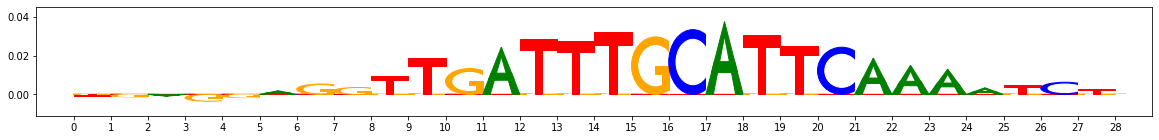

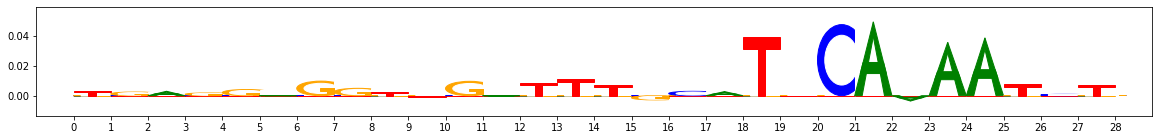

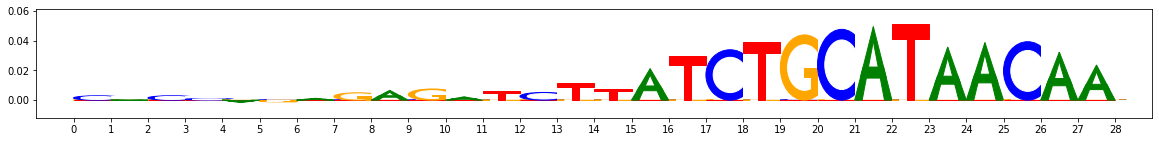

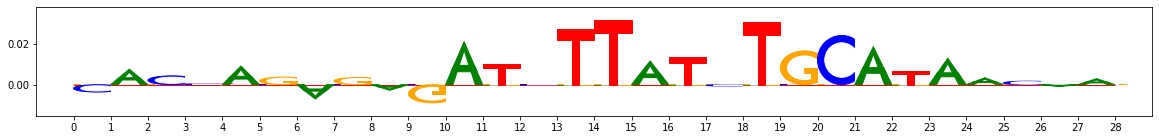

-6


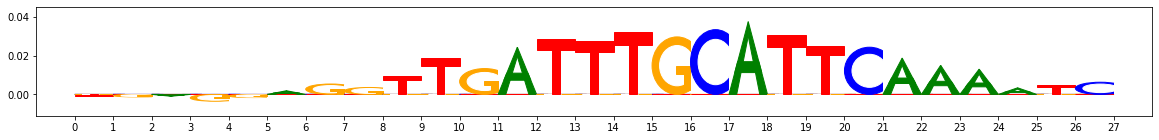

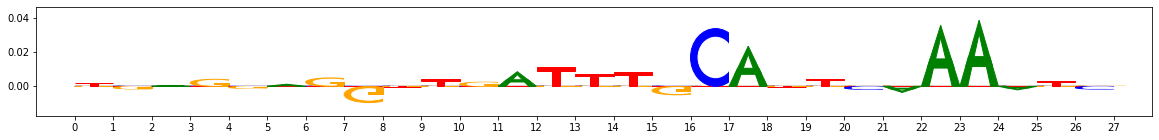

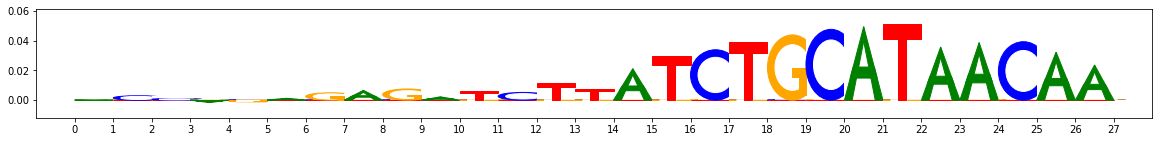

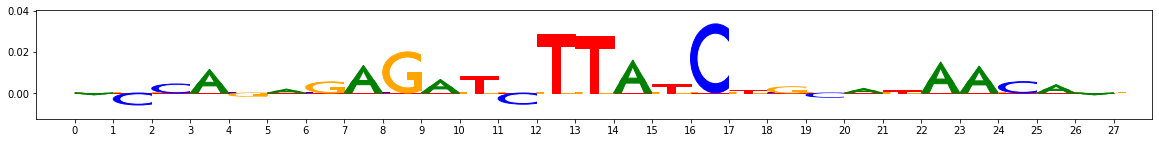

-5


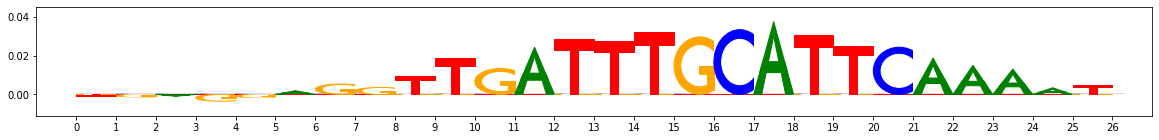

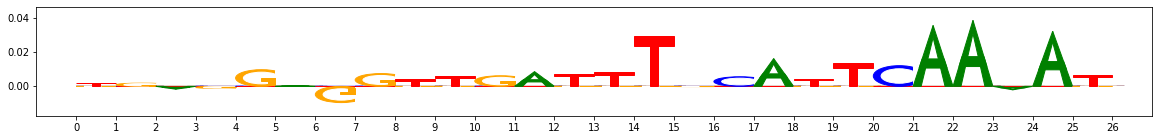

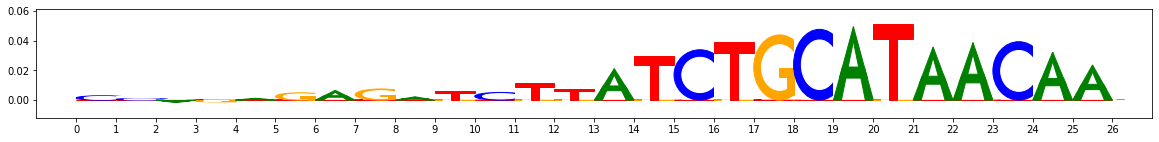

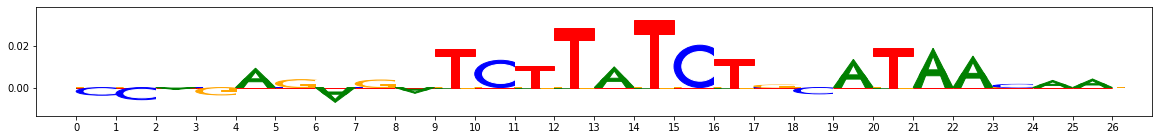

-4


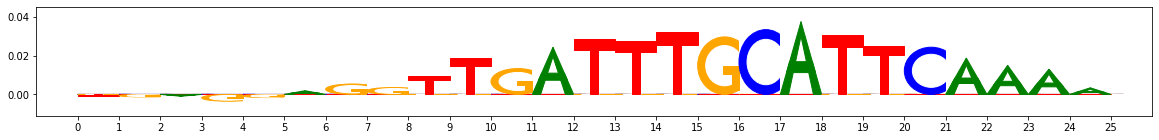

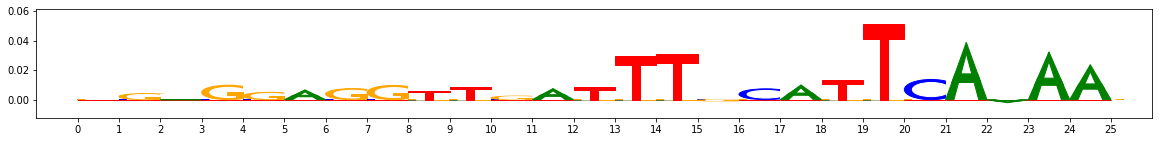

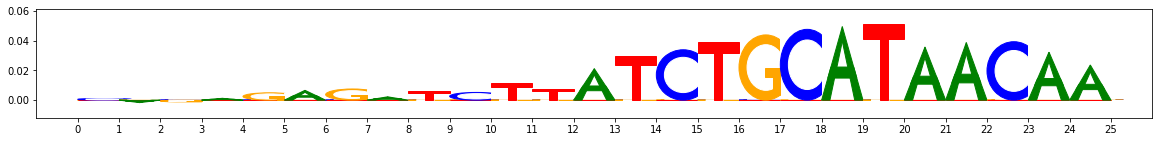

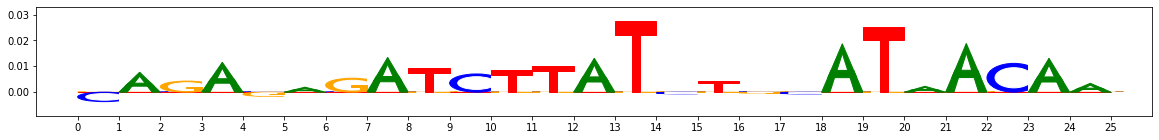

-3


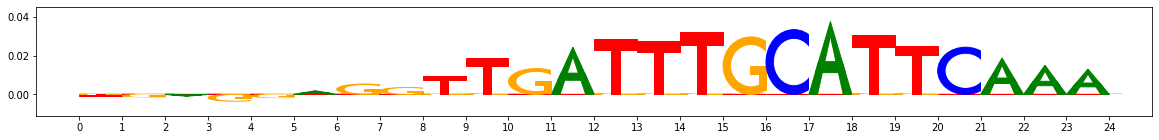

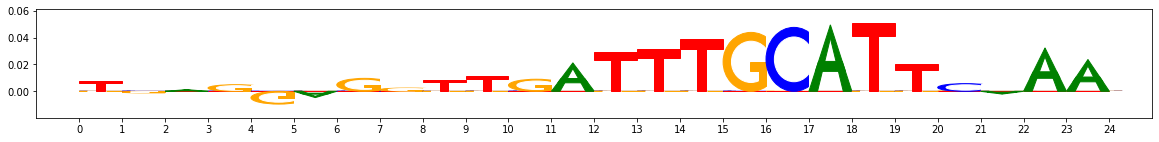

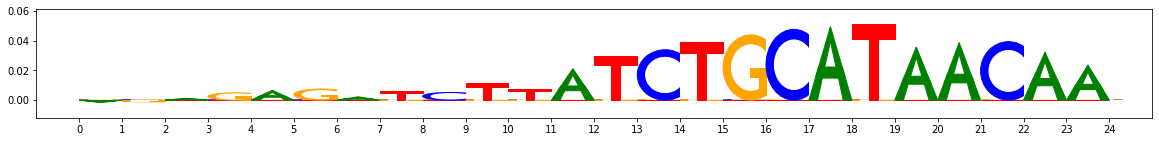

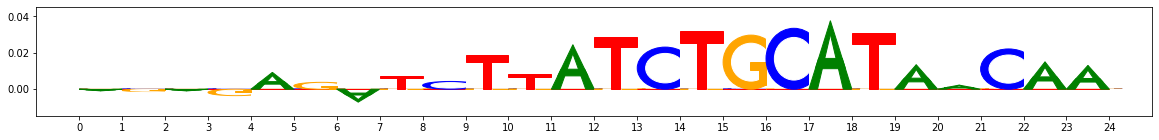

-2


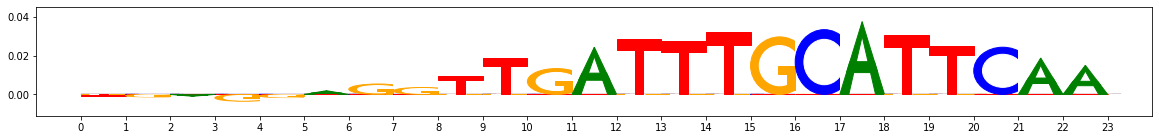

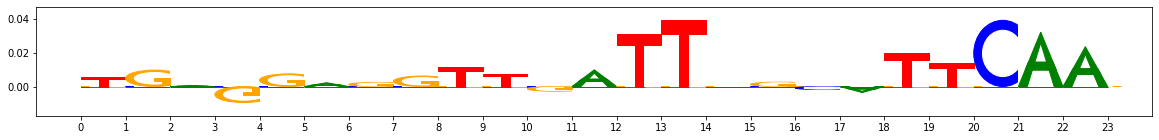

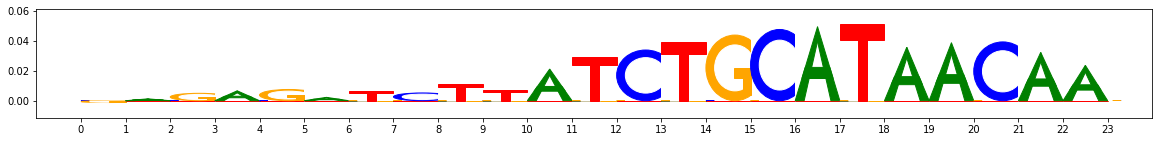

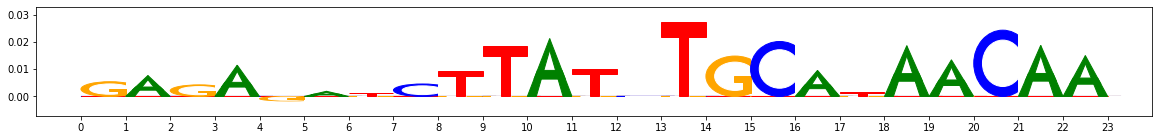

-1


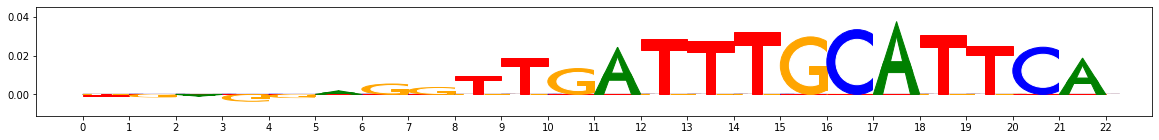

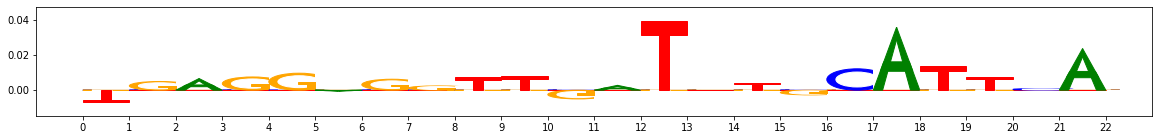

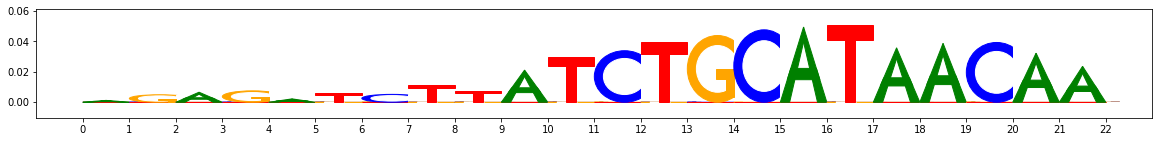

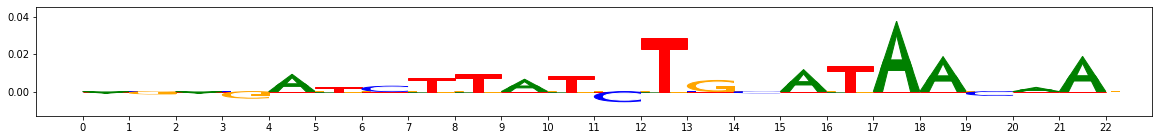

0


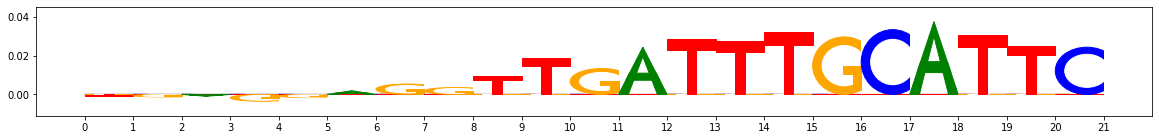

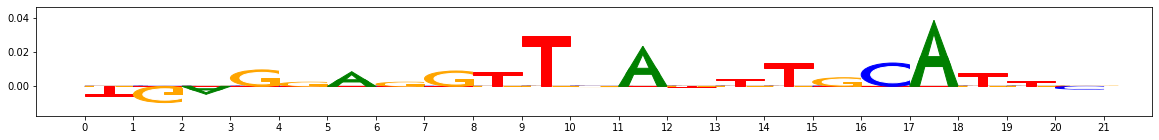

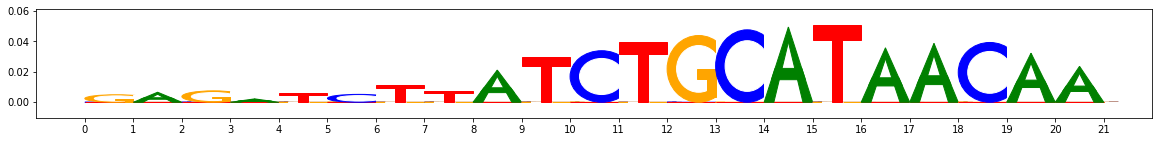

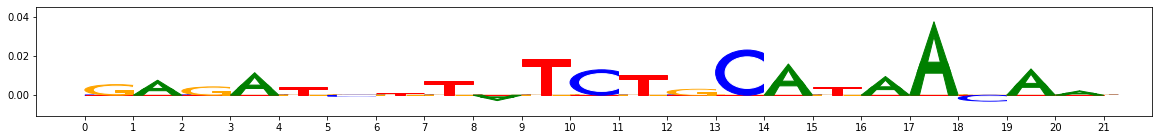

1


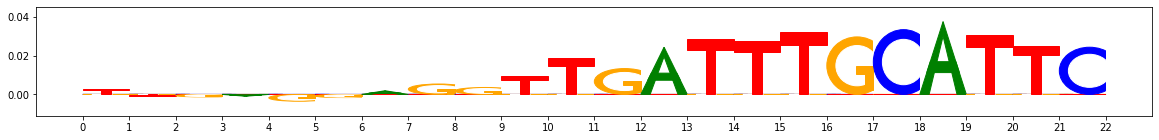

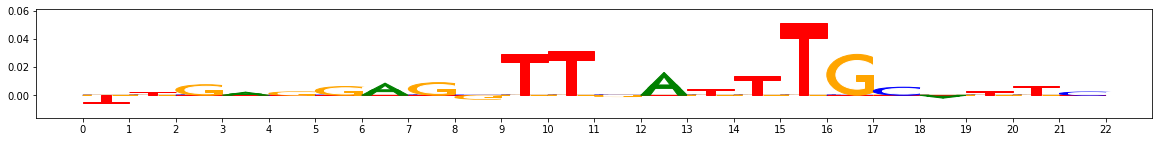

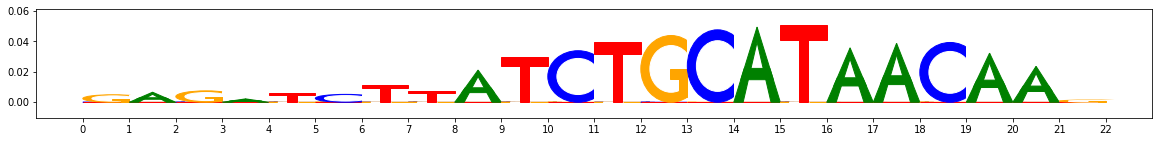

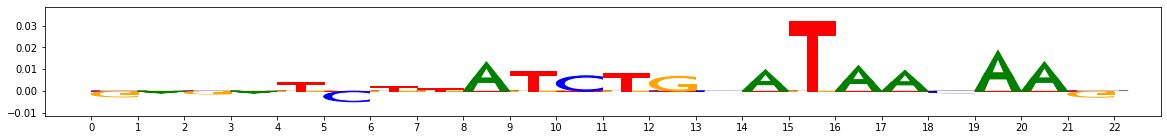

2


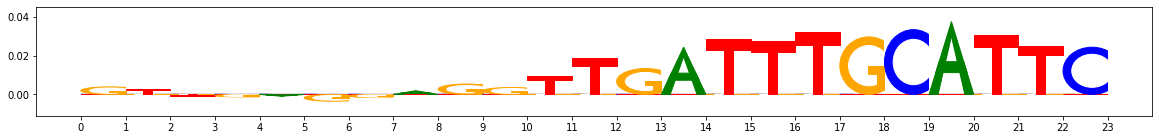

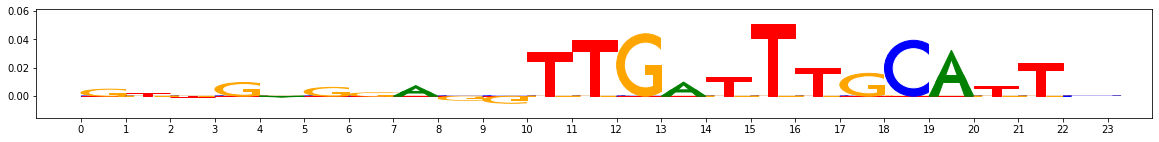

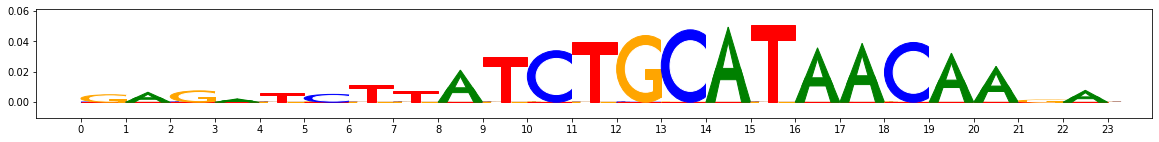

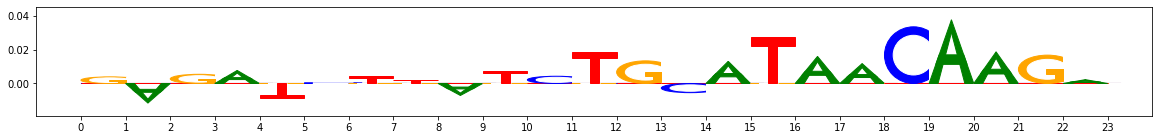

3


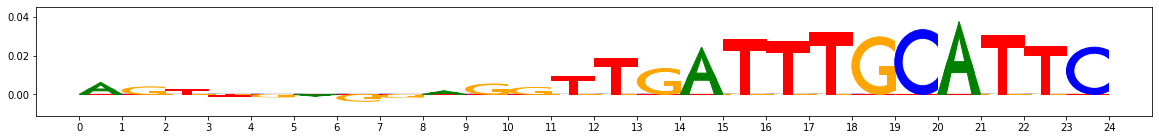

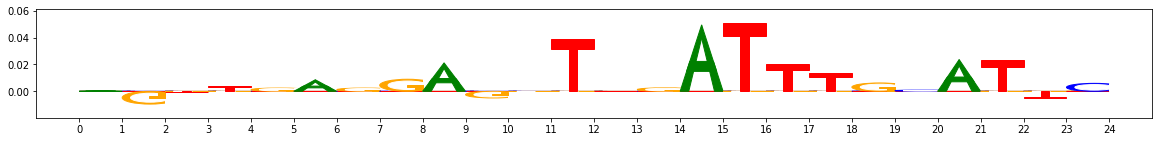

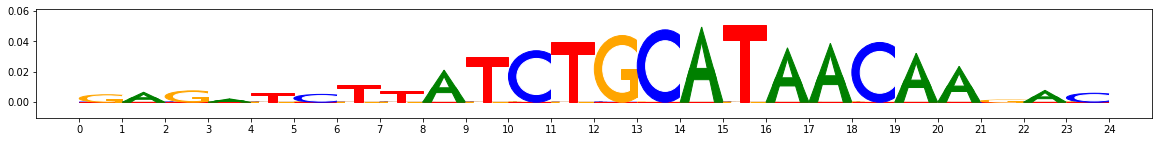

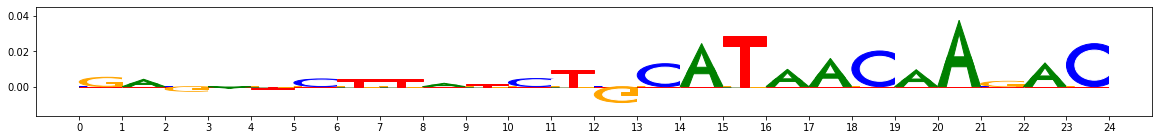

4


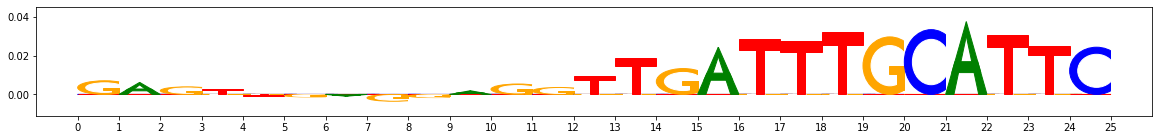

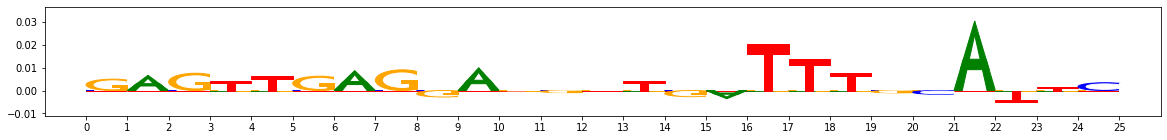

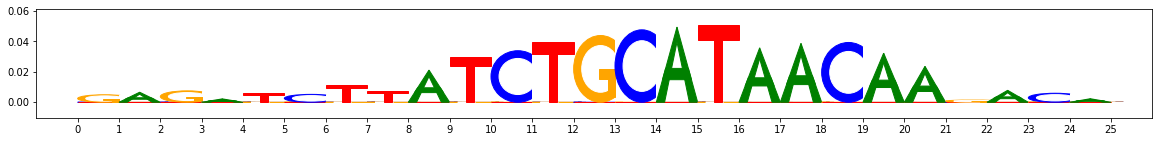

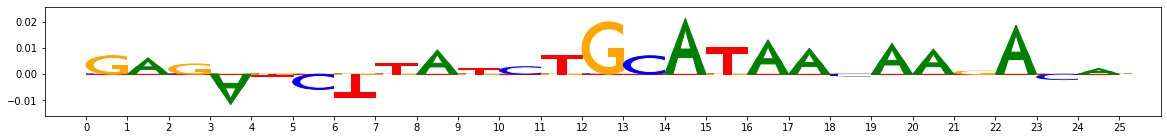

5


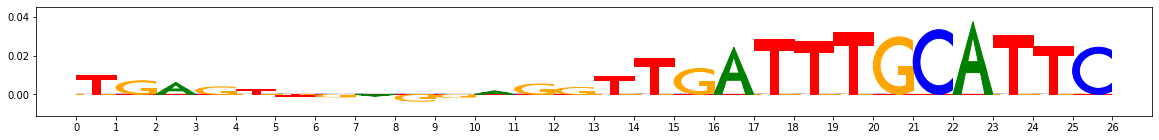

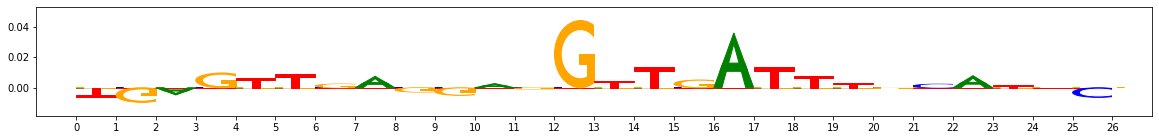

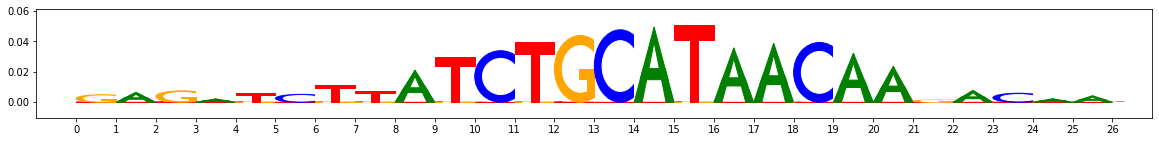

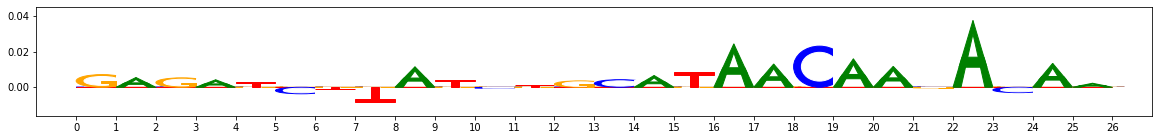

6


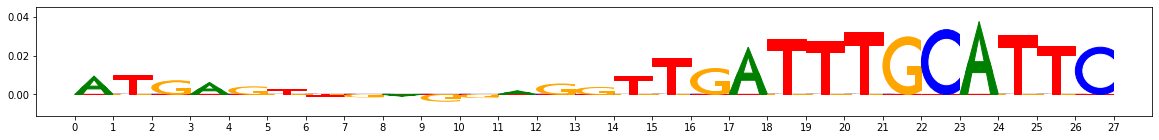

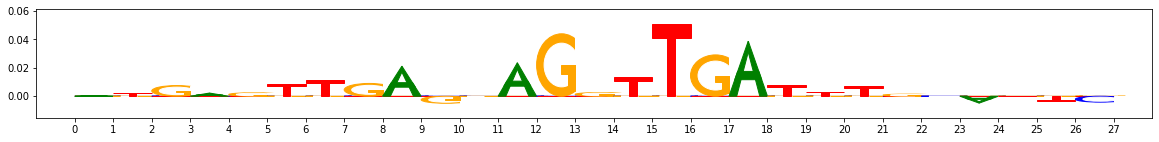

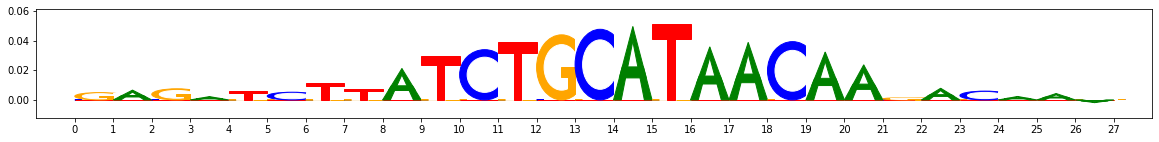

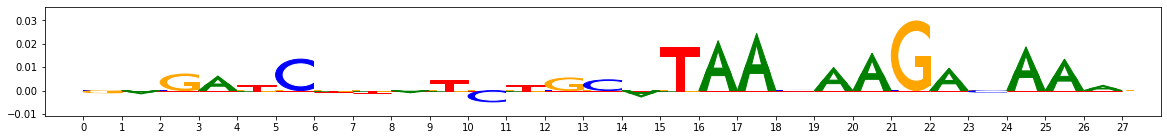

7


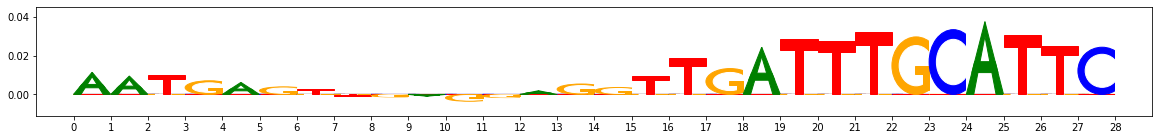

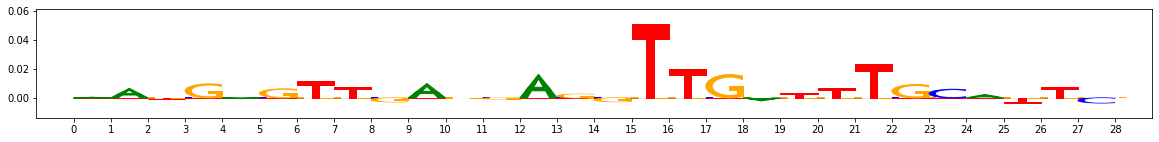

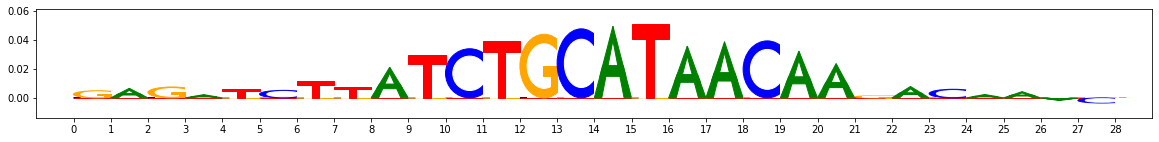

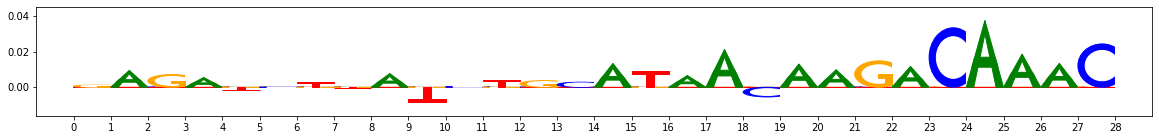

0.6816417444492913

In [108]:
compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac, modisco.util.l1norm_contin_jaccard_sim)

In [23]:
%lprun?

In [24]:
%lprun -f modisco.affinitymat.compute_sim_on_pair affmat_computer(seqlets[:100], onehot_trackname="onehot", hyp_trackname="hypcontrib_scores")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:   20.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:   19.9s finished


In [54]:
from numba import njit

def l1norm_contin_jaccard_sim(arr1, arr2):                                      
    signarr1 = np.sign(arr1)                                                    
    signarr2 = np.sign(arr2)                                                    
    absarr1 = np.abs(arr1)                                                      
    absarr1 = absarr1/np.sum(absarr1) #l1 norm                                  
    absarr2 = np.abs(arr2)                                                      
    absarr2 = absarr2/np.sum(absarr2) #l1 norm                                  
    return (np.sum(np.minimum(absarr1,absarr2)*signarr1*signarr2)/              
            np.sum(np.maximum(absarr1, absarr2)))

@njit(parallel=True)
def numba_l1norm_contin_jaccard_sim(arr1, arr2):                                      
    signarr1 = np.sign(arr1)                                                    
    signarr2 = np.sign(arr2)                                                    
    absarr1 = np.abs(arr1)                                                      
    absarr1 = absarr1/np.sum(absarr1) #l1 norm                                  
    absarr2 = np.abs(arr2)                                                      
    absarr2 = absarr2/np.sum(absarr2) #l1 norm                                  
    return (np.sum(np.minimum(absarr1,absarr2)*signarr1*signarr2)/              
            np.sum(np.maximum(absarr1, absarr2)))

In [17]:
%lprun -f compute_sim_on_pair compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac, modisco.util.l1norm_contin_jaccard_sim)

In [6]:
%load_ext line_profiler

In [7]:
def rn():
    for ix in range(0,10): print(ix)

In [9]:
%lprun -f rn rn()

0
1
2
3
4
5
6
7
8
9


In [101]:
%timeit modisco.affinitymat.compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac, modisco.util.l1norm_contin_jaccard_sim)

1.02 ms ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [60]:
%timeit l1norm_contin_jaccard_sim(arr1, arr2)

28.9 µs ± 480 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
%timeit numba_l1norm_contin_jaccard_sim(arr1, arr2)

69.7 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%timeit numba_l1norm_contin_jaccard_sim(arr1, arr2)

65.9 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
